# **Initial setup**

In [1]:
!pip install optuna
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.7 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib

# For scaling
from sklearn.preprocessing import MinMaxScaler

# For model evaluation and splitting
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV

# XGBoost model
import xgboost as xgb

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fz-fyp-new/cleaned_wind_data.csv', parse_dates=['Date/Time'])


In [ ]:
df.sort_values(by='Date/Time', inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.interpolate(method='linear', inplace=True)


In [ ]:
rated_capacity = 3600
df.loc[df['LV ActivePower (kW)'] > rated_capacity, 'LV ActivePower (kW)'] = rated_capacity

In [ ]:
cut_in_speed = 3
df.loc[df['Wind Speed (m/s)'] < cut_in_speed, 'LV ActivePower (kW)'] = 0

In [ ]:
# 4. Feature Engineering
# a. Create time-based features (if not already present)
df['Hour'] = df['Date/Time'].dt.hour
df['Month'] = df['Date/Time'].dt.month


In [ ]:
# b. Create cyclic features for Hour, Month, and Wind Direction
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

df['wd_sin'] = np.sin(np.radians(df['Wind Direction (°)']))
df['wd_cos'] = np.cos(np.radians(df['Wind Direction (°)']))

In [ ]:
# c. Create lag features for active power and wind speed (assuming data is at 10-min intervals)
df['Power_lag1'] = df['LV ActivePower (kW)'].shift(1)
df['Power_lag2'] = df['LV ActivePower (kW)'].shift(2)
df['Power_lag3'] = df['LV ActivePower (kW)'].shift(3)

df['WindSpeed_lag1'] = df['Wind Speed (m/s)'].shift(1)
df['WindSpeed_lag2'] = df['Wind Speed (m/s)'].shift(2)
df['WindSpeed_lag3'] = df['Wind Speed (m/s)'].shift(3)

In [ ]:
# d. Create rolling averages (e.g., a 3-period rolling mean for a 30-min window)
df['WindSpeed_rolling_mean_3'] = df['Wind Speed (m/s)'].rolling(window=3).mean()
df['Power_rolling_mean_3'] = df['LV ActivePower (kW)'].rolling(window=3).mean()


In [ ]:
# e. Create the target variable for a 30-min ahead forecast
df['Power_Tplus30'] = df['LV ActivePower (kW)'].shift(-3)

# f. Remove rows with NaNs generated by shifting and rolling
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
feature_cols = [
    'Wind Speed (m/s)', 'wd_sin', 'wd_cos', 'Hour_sin', 'Hour_cos',
    'Month_sin', 'Month_cos', 'Power_lag1', 'Power_lag2', 'Power_lag3',
    'WindSpeed_lag1', 'WindSpeed_lag2', 'WindSpeed_lag3',
    'WindSpeed_rolling_mean_3', 'Power_rolling_mean_3'
]

scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [ ]:
print(df.head())

            Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0 2018-01-01 00:30:00           419.645905          0.224537   
1 2018-01-01 00:40:00           380.650696          0.221294   
2 2018-01-01 00:50:00           402.391998          0.222330   
3 2018-01-01 01:00:00           447.605713          0.229826   
4 2018-01-01 01:10:00           387.242188          0.210507   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  Hour  Month  Hour_sin  \
0                     516.127569          271.258087     0      1   0.50000   
1                     491.702972          265.674286     0      1   0.50000   
2                     499.436385          264.578613     0      1   0.50000   
3                     557.372363          266.163605     1      1   0.62941   
4                     414.898179          257.949493     1      1   0.62941   

   Hour_cos  Month_sin  ...    wd_cos  Power_lag1  Power_lag2  Power_lag3  \
0  1.000000       0.75  ...  0.510978    0.085105    0.126047  

train-test split


In [ ]:
train_size = int(0.75 * len(df))
train_df = df.iloc[:train_size]
test_df  = df.iloc[train_size:]

# Define X and y for modeling
X = train_df[feature_cols]
y = train_df['Power_Tplus30']

X_test = test_df[feature_cols]
y_test = test_df['Power_Tplus30']

**hyperparameter tuning**

In [ ]:
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

# Define a broader hyperparameter space to search
param_distributions = {
    'n_estimators': [300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': list(range(3, 11)),  # 3 to 10
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 1],
    'min_child_weight': [1, 2, 5, 10]
}


In [ ]:
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_distributions,
    n_iter=100,  # try 30 random combinations
    scoring='neg_mean_squared_error',
    cv=3,       # 3-fold cross-validation
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Starting hyperparameter tuning...")
random_search.fit(X, y)

# Best hyperparameters and score
best_params = random_search.best_params_
print("Best Hyperparameters Found:")
print(best_params)

Starting hyperparameter tuning...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Hyperparameters Found:
{'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 1.0}


In [ ]:
final_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params
)

# Train on the full training set
final_xgb.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Final XGBoost Model Evaluation on Test Set:
  RMSE: 400.632
  MAE:  287.015
  R²:   0.908


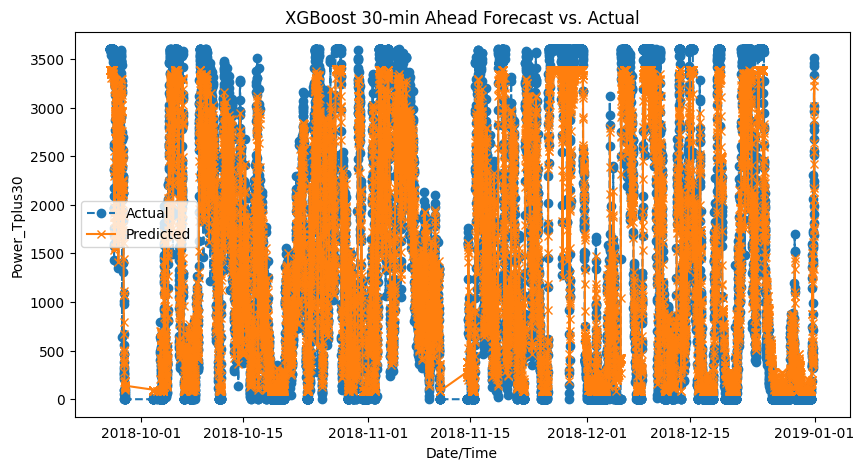

In [ ]:
y_pred = final_xgb.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("Final XGBoost Model Evaluation on Test Set:")
print(f"  RMSE: {rmse:.3f}")
print(f"  MAE:  {mae:.3f}")
print(f"  R²:   {r2:.3f}")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(test_df['Date/Time'], y_test, label='Actual', marker='o', linestyle='--')
plt.plot(test_df['Date/Time'], y_pred, label='Predicted', marker='x', linestyle='-')
plt.xlabel('Date/Time')
plt.ylabel('Power_Tplus30')
plt.title('XGBoost 30-min Ahead Forecast vs. Actual')
plt.legend()
plt.show()


In [ ]:
model_save_path = "/content/drive/MyDrive/fz-fyp-new/track 1/xgboost"
os.makedirs(model_save_path, exist_ok=True)

model_filename = os.path.join(model_save_path, "xg_tuned2.pkl")
joblib.dump(final_xgb, model_filename)
print(f"XGBoost model saved to {model_filename}")

XGBoost model saved to /content/drive/MyDrive/fz-fyp-new/track 1/xgboost/xg_tuned2.pkl


In [ ]:
import optuna

def objective(trial):
    # Suggest hyperparams
    n_estimators = trial.suggest_int('n_estimators', 300, 1000, step=100)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)

    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        min_child_weight=min_child_weight,
        random_state=42
    )

    # Use a time-based split or custom validation to evaluate
    xgb_model.fit(X, y, eval_set=[(X_test, y_test)],
                   verbose=False)

    preds = xgb_model.predict(X_test)
    mse = mean_squared_error(y_test, preds)  # older versions only do MSE
    rmse = np.sqrt(mse)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_params


[I 2025-03-22 15:07:17,439] A new study created in memory with name: no-name-6245fb22-6f2d-4b2f-8e89-030b51cd2574
[I 2025-03-22 15:07:33,131] Trial 0 finished with value: 1263.0777346597731 and parameters: {'n_estimators': 300, 'learning_rate': 0.00023724945196553984, 'max_depth': 3, 'subsample': 0.8991118090071214, 'colsample_bytree': 0.876583008650931, 'gamma': 2.187918641919911, 'min_child_weight': 2}. Best is trial 0 with value: 1263.0777346597731.
[I 2025-03-22 15:07:56,420] Trial 1 finished with value: 688.2082888269463 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0008446894126701968, 'max_depth': 9, 'subsample': 0.773718233907369, 'colsample_bytree': 0.6273569620968813, 'gamma': 4.292709407712821, 'min_child_weight': 7}. Best is trial 1 with value: 688.2082888269463.
[I 2025-03-22 15:08:06,347] Trial 2 finished with value: 940.190905352552 and parameters: {'n_estimators': 400, 'learning_rate': 0.0010392953428739482, 'max_depth': 9, 'subsample': 0.8339839973321337, '

In [ ]:
xgb_2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params
)

# Train on the full training set
xgb_2.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9486563040303826, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1.9383960934375584,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005063097557222509,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=900, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Final XGBoost Model Evaluation on Test Set:
  RMSE: 400.632
  MAE:  287.015
  R²:   0.908


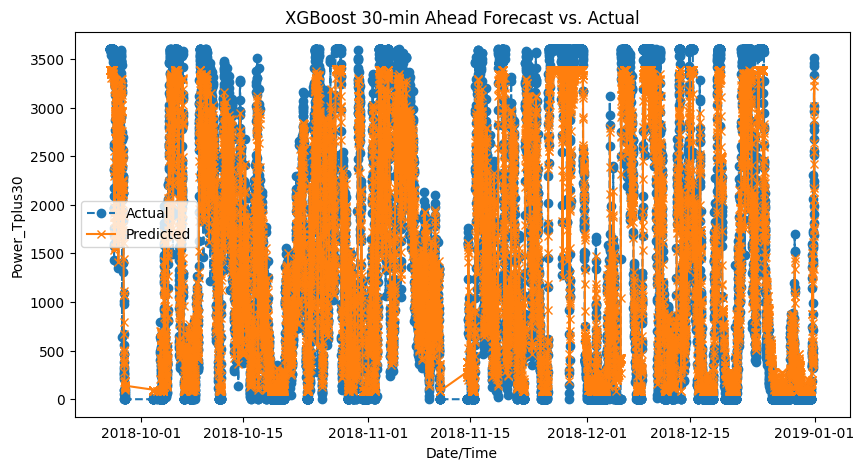

In [ ]:
y_pred = final_xgb.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("Final XGBoost Model Evaluation on Test Set:")
print(f"  RMSE: {rmse:.3f}")
print(f"  MAE:  {mae:.3f}")
print(f"  R²:   {r2:.3f}")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(test_df['Date/Time'], y_test, label='Actual', marker='o', linestyle='--')
plt.plot(test_df['Date/Time'], y_pred, label='Predicted', marker='x', linestyle='-')
plt.xlabel('Date/Time')
plt.ylabel('Power_Tplus30')
plt.title('XGBoost 30-min Ahead Forecast vs. Actual')
plt.legend()
plt.show()


In [ ]:
model_save_path = "/content/drive/MyDrive/fz-fyp-new/track 1/xgboost"
os.makedirs(model_save_path, exist_ok=True)

model_filename = os.path.join(model_save_path, "xg_tuned3.pkl")
joblib.dump(final_xgb, model_filename)
print(f"XGBoost model saved to {model_filename}")

XGBoost model saved to /content/drive/MyDrive/fz-fyp-new/track 1/xgboost/xg_tuned3.pkl
